#### Copyright 2018 The TensorFlow Authors.

##### Modifications and neural.py added by Teemu Lehti

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Comparisons of keras/tensorflow and neural.py neural network models using the fashion MNIST dataset

## Import libraries and the MNIST dataset

In [1]:
# TensorFlow and Keras
import tensorflow as tf

# Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter

### neural.py

In [2]:
#!/usr/bin/env python3
import numpy as np
from typing import Optional, Any, Tuple, List

class Layer:
    """Abstract neural network layer"""

    def __init__(self):
        """Initializes layer specific variables"""

    def build(self, prev_shape: Tuple[int, ...]) -> Tuple[int, ...]:
        """Initializes parameters of the layer and sets the output shape"""
        
        #default layer has the same shape as the previous layer
        return prev_shape

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Calculates the layer output

        :param x: previous layer output, input to this layer
        :return: output of this layer
        """

        return x

    def backward(self, da: np.ndarray) -> np.ndarray:
        """
        Calculates input (and parameter) gradients

        :param da: following layer input gradient
        :return: input gradient of this layer
        """

        return da
    
    def train(self, rate: float):
        """Updates the layer parameters using the calculated gradients and a specific learning rate"""



class ParameterLayer(Layer):
    """Abstraction of a layer with trainable weight and bias parameters"""

    def __init__(self, init_w: Optional[np.ndarray] = None, init_b: Optional[np.ndarray] = None):
        """
        Set initial weights and biases

        :param init_w: optional initial weights
        :param init_b: optional initial biases
        """

        super().__init__()
        self.params_initialized = False
        self.first_layer = False

        self.init_w = init_w
        self.init_b = init_b

    def build(self, prev_shape: Tuple[int, ...]):
        """Initializes trainable parameters if not already initialized"""

        if not self.params_initialized:
            self.init_params(prev_shape)
            self.params_initialized = True

    def init_params(self, prev_shape: Tuple[int, ...]):
        """Initializes the trainable parameters"""

    def train(self, rate: float):
        """
        Updates weigths and biases using the calculated gradients and the given learning rate

        :param rate: learning rate
        """

        # momentum update testing
        #self.vw = (mu * self.vw) + (rate * self.dw)
        #self.vb = (mu * self.vb) + (rate * self.db)

        self.w += rate * self.dw
        self.b += rate * self.db




class FC(ParameterLayer):
    """
    Implementation of a fully connected neural network layer


    Testing data:
    w = np.array([[1,2],[-3,2],[1,-1],[2,1]])
    b = np.array([2,0])
    
    x = np.array([[1, 2, 1, 4], [3, 1, 1, 4]])
    a = np.dot(x, w) + b

    da = np.array([[2, 1], [1, -3]])
    dw = np.einsum("ki,kj->ij", x, d) / len(x)
    db = np.sum(d, 0) / len(x)
    dx = np.einsum("ij,kj->ki", w, d)

    """

    def __init__(self, nodes: int, init_w: Optional[np.ndarray] = None, init_b: Optional[np.ndarray] = None):
        """
        Initializes the number of nodes in the layer and optionally initial weight and bias arrays.

        :param nodes: number of nodes in this fully connected layer
        :param init_w: optional initial weights
        :param init_b: optional initial biases
        """

        super().__init__(init_w, init_b)
        self.nodes = nodes
        
    def init_params(self, prev_shape: Tuple[int, ...]):
        """Initialize weights and biases with the Xavier initialization"""

        self.w = self.init_w if np.any(self.init_w) else np.random.normal(0, np.sqrt(1 / prev_shape[1]), (prev_shape[1], self.nodes))
        self.b = self.init_b if np.any(self.init_b) else np.zeros(self.nodes)

    def build(self, prev_shape: Tuple[int, ...]):
        """
        Sets the output shape (and initializes parameters if not already initialized). 
        The previous/input shape to this layer must be two dimensional (including the batch dimension).
        
        Data example (prev_size = prev_shape[1] = 4, connecting to 2 layer nodes):
            w = [[1, 2], [-3, 2], [1, -1], [2, 1]]              shape: (4, 2)   | (prev_size, nodes)
            b = [2, 0]                                          shape: (2)      | (nodes)

        :param prev_shape: shape of the previous layer connecting to this layer (batch_size, prev_size)
        :return: output shape of this layer (batch_size, nodes)
        """

        super().build(prev_shape)
        return (prev_shape[0], self.nodes)

    def forward(self, x: np.ndarray):
        """
        Calculates node outputs/activations for this layer with the batch input (variable x)
        from the previous layer

        Data example (4 connecting to 2 nodes with batch size 2. a is here the output array):
            x = [[1, 2, 1, 4], [3, 1, 1, 4]]                    shape: (2, 4)   | (batch_size, prev_size)
            a = [[6, 9], [11, 11]]                              shape: (2, 2)   | (batch_size, nodes)

        :param x: input to this layer
        :return: node activations (a)
        """

        self.x = x # save the input for backpropagation

        return np.dot(x, self.w) + self.b

    def backward(self, da: np.ndarray):
        """
        Calculates backpropagated gradient for this layer input, weights and biases
        with the gradients (variable da) from the following layer.

        Weight and bias gradients are saved to self.dw and self.db variables.

        Data example (4 connecting to 2 nodes with batch size 2. dx is the calculated input gradient):
            da = [[2, 1], [1, -3]]                              shape: (2, 2)   | (batch_size, nodes)
            dw = [[2.5, -4], [2.5, -0.5], [1.5, -1], [6, -4]]   shape: (4, 2)   | (prev_size, nodes)
            db = [1.5, -1]                                      shape: (2)      | (nodes)
            dx = [[4, -4, 1, 5], [-5, -9, 4, -1]]               shape: (2, 4)   | (batch_size, prev_size)

        :param da: output/activation gradients from the following layer
        :return: calculated input gradients of this layer (dx)
        """

        # example with loop (can be replaced with einsum):
        #self.dw = np.zeros(self.w.shape)
        #for i in range(len(self.x)):
        #    self.dw += np.outer(self.x[i], d[i])

        self.dw = np.einsum("ki,kj->ij", self.x, da)
        self.db = np.sum(da, 0)

        return np.einsum("ij,kj->ki", self.w, da) # sum along rows (per batch)




class Conv(ParameterLayer):
    """
    Implementation of a (2d) convolutional neural network layer.


    Testing data:
    w = np.array([[[[1,1,-1],[0,0,1],[-1,-1,-1]], [[-1,-1,1],[1,0,0],[0,0,0]], [[0,-1,1],[-1,0,0],[0,-1,0]]], 
                  [[[0,-1,0],[0,-1,-1],[0,-1,-1]], [[-1,0,1],[1,0,0],[-1,-1,-1]], [[0,1,-1],[0,-1,-1],[1,0,-1]]]])
    b = np.array([1, 0])

    x1 = np.array([[[[0,0,0],[1,0,0],[1,1,0]], [[0,0,0],[0,2,0],[0,1,0]], [[0,0,0],[1,1,0],[1,1,0]]], 
                   [[[0,0,0],[1,0,0],[1,1,0]], [[0,0,0],[0,2,0],[0,1,0]], [[0,0,0],[1,1,0],[1,1,0]]],
                   [[[0,0,0],[1,0,0],[1,1,0]], [[0,0,0],[0,2,0],[0,1,0]], [[0,0,0],[1,1,0],[1,1,0]]]])
    a1 = np.einsum("aijk,bijk->ab", x1, w) + b

    """

    def __init__(self, filters: int, filter_size: int, padding: int = 0, init_w: Optional[np.ndarray] = None, init_b: Optional[np.ndarray] = None):
        """
        Initializes the number of filters, filter size, padding and optionally initial weight and bias arrays.
        Default input padding keeps (the first two dimensions of) the output shape the same.

        :param filters: number of filters
        :param filter_size: width and height of the square filter
        :param padding: input padding, defaults to ((filter_size - 1) // 2)
        :param init_w: optional initial weights
        :param init_b: optional initial biases
        """

        super().__init__(init_w, init_b)
        self.filters = filters
        self.filter_size = filter_size
        self.stride = 1

        # input padding
        self.padding = padding if padding >= 0 else (filter_size - 1) // 2
        self.padding_total = self.padding * 2

        # output gradient padding
        self.da_padding = self.filter_size - 1 - self.padding
        self.da_padding_total = self.da_padding * 2

    def init_params(self, prev_shape: Tuple[int, ...]):
        """Initialize weights and biases with He Normal initialization"""

        self.w: Any = self.init_w if np.any(self.init_w) else np.random.normal(0, np.sqrt(2 / self.filter_size**2), self.filter_shape)
        self.b = self.init_b if np.any(self.init_b) else np.zeros(self.filters)

    def build(self, prev_shape: Tuple[int, ...]):
        """
        Initializes the weights and biases of the layer (variables w and b),
        sets the output shape and preallocates space for the zero padded input array and output gradient array.
        
        The previous/input shape must be 4 dimensional. Channel dimension is before the width and heigth channels.
        The last two dimensions must be the same, meaning input images/data must be square shaped.

        :param prev_shape: previous/input shape to this layer (batch, channels, prev_width, prev_height)
        :return: output shape of this layer (batch, filters, out_width, out_height)
        """

        # calculate output size, and output, input and filter shapes
        self.output_size: int = int((prev_shape[3] + self.padding_total - self.filter_size) / self.stride) + 1
        self.output_shape = (prev_shape[0], self.filters, self.output_size, self.output_size)
        self.filter_shape = (self.filters, prev_shape[1], self.filter_size, self.filter_size)
        self.input_shape = prev_shape

        # weight and bias initialization
        super().build(prev_shape)

        # preallocate zero padding for input array and output gradient array
        self.x = np.zeros((prev_shape[0], prev_shape[1], prev_shape[2] + self.padding_total, prev_shape[3] + self.padding_total))
        self.da = np.zeros((prev_shape[0], self.filters, self.output_size + self.da_padding_total, self.output_size + self.da_padding_total))

        # padding endpoints
        self.padding_end = self.padding + prev_shape[2]
        self.da_padding_end = self.da_padding + self.output_size

        return self.output_shape
        
    def forward(self, x: np.ndarray):
        """
        Calculates the output for this layer with the batch input (variable x)
        from the previous layer. Output for this layer is the cross-correlation with weights to the input.

        :param x: batch input
        :return: result of the cross-correlation with weights to the batch input
        """

        # save input with padding
        self.x[:,:,self.padding:self.padding_end,self.padding:self.padding_end] = x

        return self._convolve("aijk,bijk->ab", self.output_shape, self.filter_size, self.x, self.w, self.b)

    def backward(self, da: np.ndarray):
        """
        Calculates backpropagated gradient for this layer input, weights and biases
        with the gradients (variable da) from the following layer.

        Weight and bias gradients are saved to self.dw and self.db variables.

        :param da: output/activation gradients from the following layer
        :return: calculated input gradients of this layer (dx) or None if this is the first layer
        """

        # convolution of input and loss gradients -> weight filter gradients
        self.dw = self._convolve("cbij,caij->ab", self.filter_shape, self.output_size, self.x, da) 
        self.db = np.sum(da, axis=(0,2,3))

        # skip input gradient calculation if this is the first layer
        if self.first_layer:
            return None

        # padded loss gradients
        self.da[:,:,self.da_padding:self.da_padding_end, self.da_padding:self.da_padding_end] = da

        # convolution of padded loss gradients and flipped filters -> input gradients
        return self._convolve("acij,cbij->ab", self.input_shape, self.filter_size, self.da, self.w[:,:,::-1,::-1]) 

    def _convolve(self, operation: str, output_shape: Tuple[int, ...], filter_size: int, inp, filt, bias = 0):
        """
        Applies a given einsum operation for each sliding window in input array 'inp' of size 'filter_size' with filter 'filt'
        and optionally adds a bias to the result. 

        :param operation: einsum operation to apply to each sliding window
        :param output_shape: output shape of the convolution
        :param filter_size: size of the convolved filter/window (width and heigth)
        :param inp: array to be convolved
        :param filt: array to apply to each sliding window of inp
        :param bias: optional bias to apply to the einsum operation result

        :return: array of convolved einsum operation results
        """

        a = np.empty(output_shape)

        for i in range(output_shape[2]):
            for j in range(output_shape[2]):
                a[:,:,i,j] = np.einsum(operation, inp[:,:,i:(i + filter_size), j:(j + filter_size)], filt) + bias

        return a



class MaxPool(Layer):
    """
    Implementation of a non-overlapping max pooling layer
    """

    def __init__(self, size: int):
        """
        Initializes the size of the pooling window (width and height).
        Input image dimensions must be divisible by this size (this pooling is always non-overlapping)

        :param size: size of the pooling window (width and height)
        """

        super().__init__()
        self.size = size
        self.flat_size = size ** 2

    def build(self, prev_shape: Tuple[int, ...]):
        """
        (Re)calculate output size and save the previous layer size and 
        initialize empty array where the maximum indexes are saved.

        :param prev_shape: output shape of the previous layer
        :return: output shape of this layer
        """

        self.prev_shape = prev_shape
        self.output_size = prev_shape[3] // self.size
        self.flat_batch_channels = prev_shape[0] * prev_shape[1]

        # array to save maximum indexes into (indexes that have the maximum values)
        self.ind = np.empty((self.flat_batch_channels, self.output_size, self.output_size))

        return (prev_shape[0], prev_shape[1], self.output_size, self.output_size)

    def forward(self, x: np.ndarray):
        """
        Calculates the max pooled/scaled output for the input x.

        Reduces each pooling window slice of the input to the max value of that window and
        saves the indexes of those max values for the backward pass.

        :param x: previous layer output
        :return: output of this layer
        """

        a = np.empty((x.shape[0], x.shape[1], self.output_size, self.output_size))

        # This could be cleaner and more efficient... 
        # I couldn't find an easy way to combine this pooling into a single operation while calculating indexes for backpropagation (with numpy only)
        for i, ii in zip(range(0, x.shape[3], self.size), range(self.output_size)):
            for j, jj in zip(range(0, x.shape[3], self.size), range(self.output_size)):
                win = x[:,:, i:(i + self.size), j:(j + self.size)].reshape(self.flat_batch_channels, self.flat_size) # reshaped flat window
                self.ind[:, ii, jj] = win.argmax(axis=1) # get maximum indexex

                # get maximum values with the indexes
                a[:,:,ii,jj] = np.array([win[f].take(self.ind[f, ii, jj]) for f in range(self.flat_batch_channels)]).reshape(x.shape[0], x.shape[1])
                
        return a

    def backward(self, da: np.ndarray):
        """
        Calculates the input gradient using the indexes from the forward pass.

        The following layer gradient directly flows to the max indexes of the pooling windows
        and it is zero everywhere else.

        :param da: following layer input gradient
        :return: input gradient of this layer
        """

        # previous layer output shape, possibly with a new batch size
        d = np.zeros((da.shape[0], *self.prev_shape[1:4])) 

        for i, ii in zip(range(0, self.prev_shape[3], self.size), range(self.output_size)):
            for j, jj in zip(range(0, self.prev_shape[3], self.size), range(self.output_size)):
                win = d[:,:, i:(i + self.size), j:(j + self.size)].reshape(self.flat_batch_channels, self.flat_size) # reshaped flat window
                da_flat = da[:,:,ii,jj].reshape(self.flat_batch_channels)

                # put gradient to indexes that had maximum indexes
                for f in range(self.flat_batch_channels):
                    win[f].put(self.ind[f, ii, jj], da_flat[f])

                # reshape flat window back to non-flat indexes
                d[:,:, i:(i + self.size), j:(j + self.size)] = win.reshape(*self.prev_shape[0:2], self.size, self.size)

        return d
        


class Relu(Layer):
    """
    Implementation of a ReLU neural network layer (max(0, x))
    """

    def forward(self, x: np.ndarray):
        """
        Calculates the layer output.
        Also precalculates a part of the input gradient and saves it to dx variable.
        (partial derivatives to ReLU output, not to the loss function)

        :param x: previous layer output
        :return: output of this layer
        """

        self.dx = np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def backward(self, da: np.ndarray):
        return self.dx * da


class Sigmoid(Layer):
    def forward(self, x: np.ndarray):
        s = 1.0 / (1.0 + np.exp(-x))
        self.ds = s * (1.0 - s)
        return s

    def backward(self, da: np.ndarray):
        return self.ds * da


class Tanh(Layer):
    def forward(self, x: np.ndarray):
        t = np.tanh(x)
        self.dt = 1.0 - (t ** 2)
        return t

    def backward(self, da: np.ndarray):
        return self.dt * da



class Flatten(Layer):
    """Flatten the layer input into two dimensions (batch dimension and one output dimension)"""

    def build(self, prev_shape: Tuple[int, ...]) -> Tuple[int, ...]:
        self.prev_shape = prev_shape
        self.output_shape = (prev_shape[0], np.prod(prev_shape[1:]))
        
        return self.output_shape

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.reshape(x, self.output_shape)

    def backward(self, da: np.ndarray) -> np.ndarray:
        return np.reshape(da, self.prev_shape)
    



class Model:
    """
    Classifier neural network model that implements functions to do operations to 
    a list of neural network layers, like predict and train with specified input data.
    """

    def __init__(self, layers: List[Layer]):
        """
        Initializes the model with the input data shape and layers.

        :param input_shape: input shape
        :param layers: list of neural network layers
        """
        self.layers = layers
        self.input_shape = None

    def build(self, input_shape: Tuple[int, ...]):
        """
        Calls build on every layer sequentially and gives the layer output shape to the next layer.

        :param input_shape: shape of the input data
        """

        prev_shape = input_shape
        for i, layer in enumerate(self.layers):
            # Signal to the first layer that it doesn't need to calculate input gradients
            if i == 0 and isinstance(layer, ParameterLayer):
                layer.is_first_layer = True
            
            prev_shape = layer.build(prev_shape)

    def __call__(self, x: np.ndarray):
        """
        Forward pass of the network that calculates the layer activations for a single batch.

        :param x: input data batch
        :return: last layer activations/outputs
        """

        # Rebuild layers if input shape is not set or it changes
        if self.input_shape == None or self.input_shape != x.shape:
            self.build(x.shape)

        # Forward pass for each layer
        a = x
        for layer in self.layers:
            a = layer.forward(a)

        return a

    def predict(self, a: np.ndarray):
        """
        Calculates the prediction for this input data batch with the last layer activations.

        :param a: last layer activations
        :return: prediction label index
        """
        
        return np.argmax(a, axis=1)


    def evaluate(self, x: np.ndarray, y: np.ndarray, a: Optional[np.ndarray] = None):
        """
        Evaluates network accuracy performance with specific input data and output labels.

        :param x: input data
        :param y: output labels
        :param a: optional precalculated activations for this input data
        :return: tuple of accuracy, (percentage of correct predictions) and the number of correct predictions
        """

        # calculate activations if not given
        if not np.any(a):
            a = self(x)

        correct_pred = 0
        for (pred, label) in zip(self.predict(a), y):
            if label[pred] == 1:
                correct_pred += 1

        return correct_pred / len(x), correct_pred

    def train(self, x: np.ndarray, y: np.ndarray, rate: float):
        """
        Trains the network with given input data, corresponding output labels and a learning rate.

        :param x: input data
        :param y: output labels
        :param rate: learning rate
        :return: loss, evaluation and a tuple of last layer activations and partial loss gradients
        """

        a = self(x)
        loss, dy = self.loss(a, y)
        
        d = dy
        for layer in reversed(self.layers):
            d = layer.backward(d)
            layer.train(rate)

        return loss, self.evaluate(x, y, a)[0], (a, dy)

    def loss(self, a: np.ndarray, y: np.ndarray) -> Tuple:
        """
        Returns loss and its partial derivatives for 
        specific output layer activations and corresponding output labels

        :param a: last layer outputs/activations
        :param y: correct outputs for corresponding input data
        :return: 2-tuple of loss and its partial derivatives
        """

        return (np.sum((a - y)**2, 1), 2*(a - y))

### MNIST data

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# convert to one-hot encoding. (neural.py presumes one-hot encoded labels)
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

4431872/4422102 [==============================] - 0s 0us/step


In [34]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Build the models for keras/tensorflow and neural.py

Keras:

In [ ]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid') #activation='softmax')
])

neural.py:

In [31]:
model = Model([
    Flatten(),
    FC(128), Relu(),
    FC(10), Sigmoid()
])

### Compile the model (tensorflow only. neural.py doesn't need to be compiled)

In [ ]:
model_tf.compile(
    #optimizer='adam',
    optimizer=tf.keras.optimizers.SGD(), # using the default learning rate 0.01
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # categorical crossentropy uses one-hot encoding
    metrics=['accuracy']
)

## Train the models

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


In [ ]:
model_tf.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7339 - accuracy: 0.7630
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5116 - accuracy: 0.8254
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4670 - accuracy: 0.8382
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4422 - accuracy: 0.8484
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4242 - accuracy: 0.8522
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4110 - accuracy: 0.8569
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3986 - accuracy: 0.8618
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3890 - accuracy: 0.8639
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3799 - accuracy: 0.8673
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.372

Helper train function for neural.py. 

Adapted from chess_cnn.py. Changed to similar loss and accuracy printing to keras fit()

In [6]:
def train(model, X_train, y_train, epochs, batch_count):
  batches = len(X_train) // batch_count

  for epoch in range(epochs):
    # Decreasing learning rate gradually (neural.py uses a negative learning rate)
    learning_rate = -0.01 if epoch < 6 else -0.003# if epoch < 15 else (-0.000021 if epoch < 20 else -0.000015))
    print(f"\nEpoch: {epoch+1}/{epochs}  |  Learning rate: {learning_rate}")

    epoch_acc = 0
    epoch_loss = 0
    epoch_start = perf_counter()

    # Train batch slices
    for b in range(batches):
      slice_start, slice_end = b * batch_count, (b+1) * batch_count
      loss, acc, _ = model.train(X_train[slice_start:slice_end], y_train[slice_start:slice_end], learning_rate)
      epoch_loss += np.average(loss)
      epoch_acc += acc
      print(f"\r{b+1}/{batches} - {int(perf_counter() - epoch_start)}s  |  Loss: {epoch_loss / (b+1):.4f}  |  Accuracy: {epoch_acc / (b+1):.4f}            ", flush=True, end="")

    # Reshuffle training data and labels (to prevent training in exactly the same order in the next epoch)
    rng_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.set_state(rng_state)
    np.random.shuffle(y_train)

Train neural.py model

In [ ]:
train(model, train_images, train_labels, epochs=10, batch_count=32)


Epoch: 1/10  |  Learning rate: -0.01
1875/1875 - 26s  |  Loss: 0.2979  |  Accuracy: 0.7953            
Epoch: 2/10  |  Learning rate: -0.01
1875/1875 - 26s  |  Loss: 0.2176  |  Accuracy: 0.8526            
Epoch: 3/10  |  Learning rate: -0.01
1875/1875 - 25s  |  Loss: 0.1975  |  Accuracy: 0.8677            
Epoch: 4/10  |  Learning rate: -0.01
1875/1875 - 26s  |  Loss: 0.1868  |  Accuracy: 0.8752            
Epoch: 5/10  |  Learning rate: -0.01
1875/1875 - 25s  |  Loss: 0.1781  |  Accuracy: 0.8814            
Epoch: 6/10  |  Learning rate: -0.01
1875/1875 - 27s  |  Loss: 0.1718  |  Accuracy: 0.8862            
Epoch: 7/10  |  Learning rate: -0.003
1875/1875 - 27s  |  Loss: 0.1521  |  Accuracy: 0.8992            
Epoch: 8/10  |  Learning rate: -0.003
1875/1875 - 27s  |  Loss: 0.1493  |  Accuracy: 0.9010            
Epoch: 9/10  |  Learning rate: -0.003
1875/1875 - 27s  |  Loss: 0.1469  |  Accuracy: 0.9040            
Epoch: 10/10  |  Learning rate: -0.003
1875/1875 - 26s  |  Loss: 0.14

There is a clear performance difference between tensorflow and neural.py. Tensorflow training took 40 seconds and neural.py 240 seconds.

neural.py only uses numpy optimizations. Multiple batches could be run in parallel for example.

### Evaluate accuracy

Keras test accuracy:

In [ ]:
test_loss, test_acc = model_tf.evaluate(test_images,  test_labels, verbose=2)

print(f'Test accuracy: {test_acc:.4f}')

313/313 - 1s - loss: 0.4096 - accuracy: 0.8569 - 541ms/epoch - 2ms/step
Test accuracy: 0.8569


neural.py test accuracy:

In [ ]:
test_acc, _ = model.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.8827



neural.py happened to have better accuracy. I should note that neural.py learning rate was decreased on the seventh epoch, but tensorflow learning rate was always 0.01. Weight initializations were also different. 

Switching the keras model to use adam optimizer gave slightly higher accuracy (training ~0.91, test ~0.88).

### Make predictions

With the model trained, you can use it to make predictions about some images.

For keras model:

In [ ]:
predictions_tf = model_tf.predict(test_images)
predictions_tf[0]

array([0.01423395, 0.00650918, 0.02956617, 0.02065778, 0.01508933,
       0.99613214, 0.06678405, 0.9971032 , 0.93117   , 0.9993923 ],
      dtype=float32)

For neural.py model:

Calling (`__call__()`) the neural.py model object gives these predictions / last layer activations (forward pass).

In [ ]:
predictions = model(test_images)
predictions[0]

array([1.68755509e-04, 8.80249277e-04, 7.38880064e-05, 1.17767762e-05,
       5.49329030e-05, 3.47985907e-02, 7.15172842e-06, 2.25330493e-02,
       1.98446725e-04, 9.52305679e-01])

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. 

neural.py model's predict function is just a call to np.argmax that can be used to give the index of the maximum class from these activations.

In [ ]:
model.predict(predictions)[0]

9

So, the model is most confident that the first image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [32]:
# Reverse the one-hot encoding of test_labels
test_labels_flat = model.predict(test_labels)
test_labels_flat[0]

9

Graph helper functions:

In [29]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_image_table(num_rows, num_cols, predictions, test_labels, test_images):
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
  plt.tight_layout()
  plt.show()


### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's plot several images with their predictions. 

For keras:

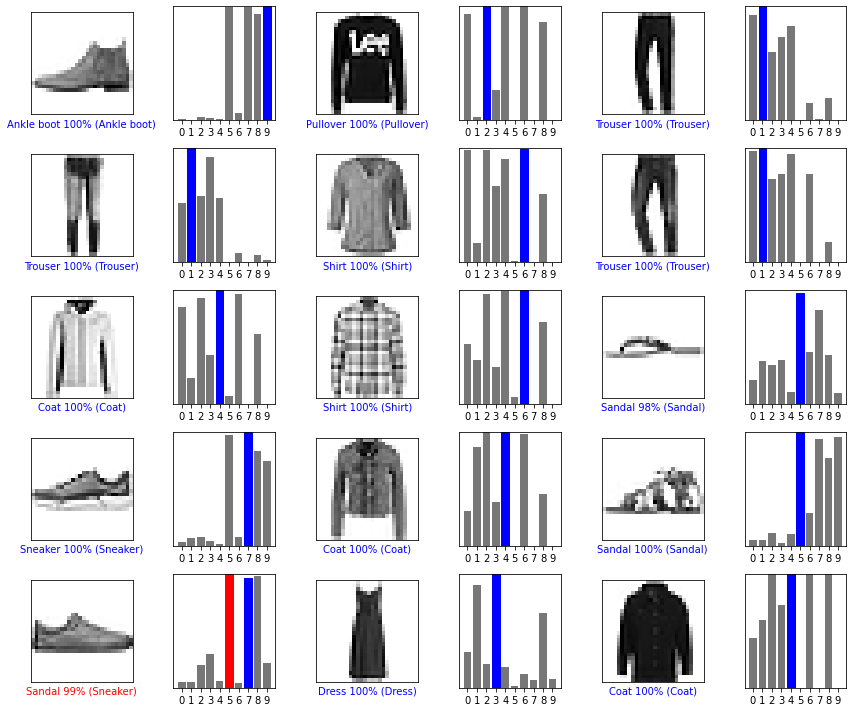

In [ ]:
plot_image_table(5, 3, predictions_tf, test_labels_flat, test_images)


For neural.py:

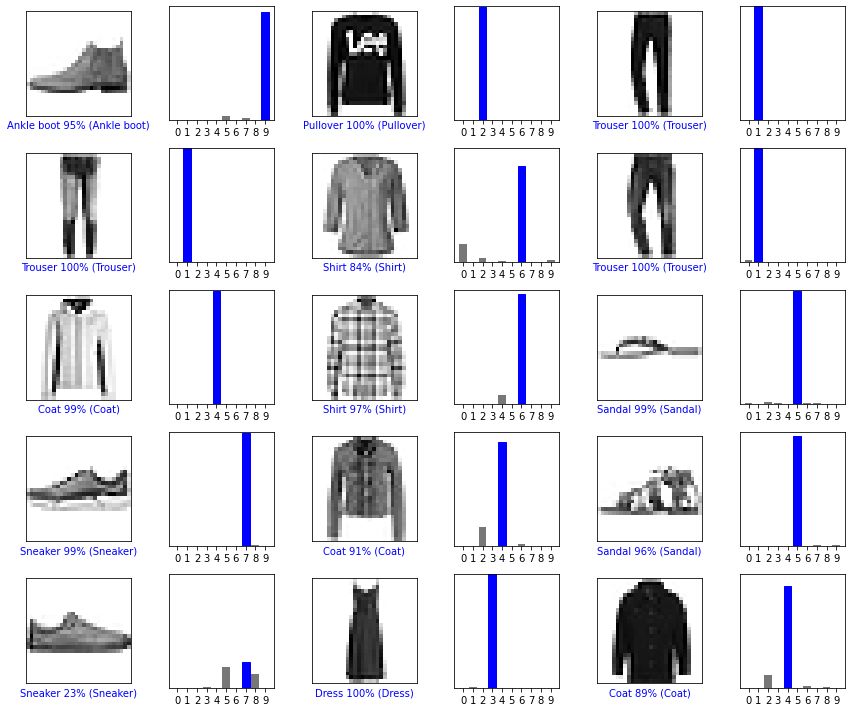

In [ ]:
plot_image_table(5, 3, predictions, test_labels_flat, test_images)

## Convolutional network test

Just a proof of concept model. Not optimized

In [23]:
# Add channel dimension (neural.py presumes channel dimension before image width and height)
train_images_c = np.expand_dims(train_images, 1)
test_images_c = np.expand_dims(test_images, 1)

print(train_images.shape, train_images_c.shape)

model_conv = Model([
    Conv(4, 5, 0), Relu(),#filters, filter_size, padding
    MaxPool(6),
    Flatten(),
    FC(10), Sigmoid()
])

(60000, 28, 28) (60000, 1, 28, 28)


In [24]:
train(model_conv, train_images_c, train_labels, epochs=2, batch_count=60)


Epoch: 1/2  |  Learning rate: -0.01
1000/1000 - 70s  |  Loss: 0.3868  |  Accuracy: 0.7368            
Epoch: 2/2  |  Learning rate: -0.01
1000/1000 - 69s  |  Loss: 0.2820  |  Accuracy: 0.8182            

Test accuracy: 0.8130


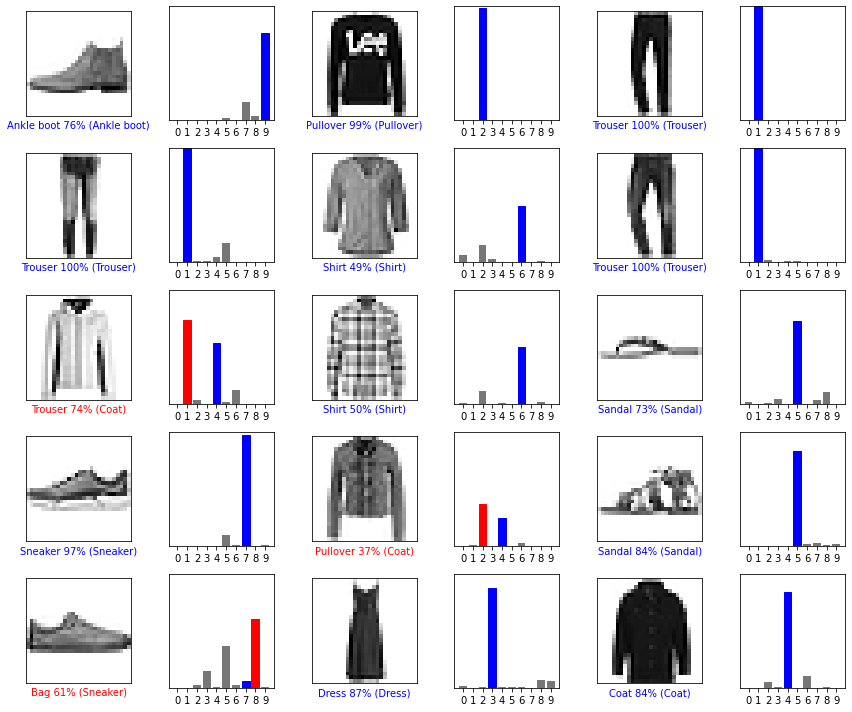

In [35]:
test_acc, _ = model_conv.evaluate(test_images_c, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

predictions_c = model_conv(test_images_c)

plot_image_table(5, 3, predictions_c, test_labels_flat, test_images)